# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

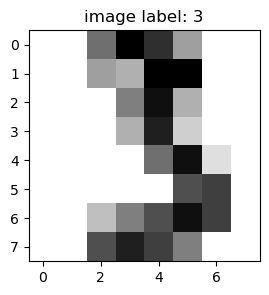

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

In [4]:
# Full class distribution across all samples

np.bincount(y_train)          # for training set
np.bincount(y_test)           # for test set
np.bincount(np.concatenate([y_train, y_test]))  # for full dataset


array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180])

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [5]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [6]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [7]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [8]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [9]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [10]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [11]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [12]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [13]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [14]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [15]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [16]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

**YOUR TURN:**

1. Implement the `forward` method of the `LogisticRegression` class. This method should take in a batch of samples `X` and return the predicted probabilities for each class. You should use the softmax function that we implemented earlier.
2. Implement the `loss` method of the `LogisticRegression` class. This method take in the samples `X` and the true values `y` and return the average negative log likelihood of the predictions.

In [17]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y.astype(int))
        Y_pred = self.forward(X)
        return nll(y_onehot, Y_pred)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b
    
# Raise an exception if you try to run this cell without having implemented the LogisticRegression class
model = LogisticRegression(input_size=64, output_size=10)
try:
    assert(model.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(model.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the LogisticRegression class.")

In [18]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

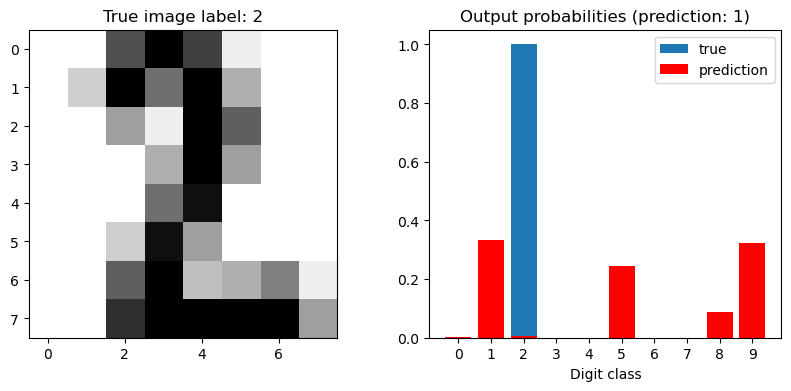

In [19]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)
    

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [20]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: -0
Average NLL over the last 100 samples at step 100: 320
Average NLL over the last 100 samples at step 200: 99
Average NLL over the last 100 samples at step 300: 107
Average NLL over the last 100 samples at step 400: 84
Average NLL over the last 100 samples at step 500: 119
Average NLL over the last 100 samples at step 600: 34
Average NLL over the last 100 samples at step 700: 57
Average NLL over the last 100 samples at step 800: 144
Average NLL over the last 100 samples at step 900: 111
Average NLL over the last 100 samples at step 1000: 51
Average NLL over the last 100 samples at step 1100: 109
Average NLL over the last 100 samples at step 1200: 225
Average NLL over the last 100 samples at step 1300: 285
Average NLL over the last 100 samples at step 1400: 28
Average NLL over the last 100 samples at step 1500: 190


Evaluate the trained model on the first example:

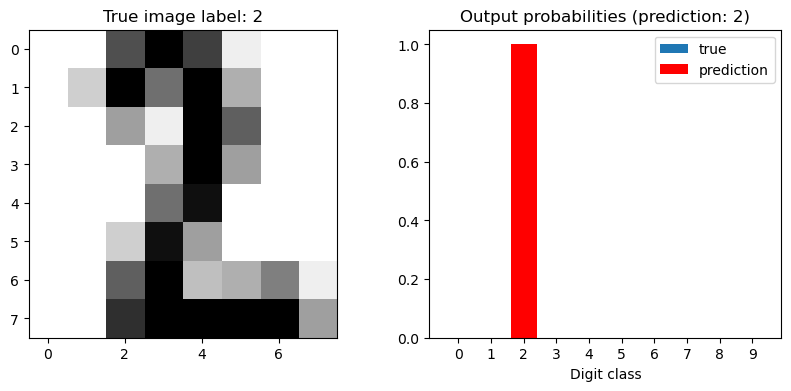

In [21]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

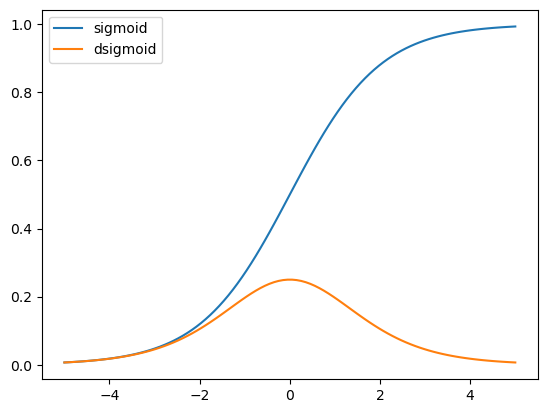

In [22]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X))


def dsigmoid(X):
    return sigmoid(X) * (1 - sigmoid(X))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [23]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the sigmoid activation function
        return sigmoid(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)

        return Y

    def loss(self, X, y):
        y_true = one_hot(self.output_size, y.astype(int)) 
        y_pred = self.forward(X)
        return nll(y_true, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)
    
# Raise an exception if you try to run this cell without having implemented the NeuralNet class
nn = NeuralNet(input_size=64, hidden_size=32, output_size=10)
try:
    assert(nn.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(nn.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the NeuralNet class.")

Once the code is written, we can test our model on a single sample:

In [24]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [25]:
model.loss(X_train, y_train)

1067.2425306299654

In [26]:
model.accuracy(X_train, y_train)

0.10019646365422397

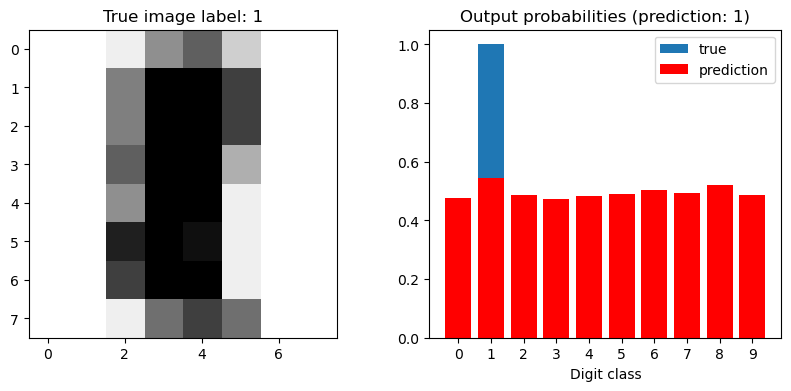

In [27]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [28]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 1067.24253, train acc: 0.100, test acc: 0.107
Epoch #1, train loss: 3243.71049, train acc: 0.269, test acc: 0.226
Epoch #2, train loss: 2781.84498, train acc: 0.392, test acc: 0.348
Epoch #3, train loss: 2350.98269, train acc: 0.633, test acc: 0.570
Epoch #4, train loss: 1904.67673, train acc: 0.749, test acc: 0.722
Epoch #5, train loss: 1554.96136, train acc: 0.802, test acc: 0.789
Epoch #6, train loss: 1310.20058, train acc: 0.877, test acc: 0.844
Epoch #7, train loss: 1130.83609, train acc: 0.910, test acc: 0.863
Epoch #8, train loss: 984.49261, train acc: 0.918, test acc: 0.896
Epoch #9, train loss: 932.50116, train acc: 0.921, test acc: 0.907
Epoch #10, train loss: 838.70494, train acc: 0.936, test acc: 0.915
Epoch #11, train loss: 755.73550, train acc: 0.938, test acc: 0.904
Epoch #12, train loss: 676.58224, train acc: 0.944, test acc: 0.907
Epoch #13, train loss: 631.11530, train acc: 0.946, test acc: 0.900
Epoch #14, train loss: 578.71686, train acc: 0.

**Learning curve**
- Initial State

    Train loss: 1067.24253, Train acc: 10.0%, Test acc: 10.7% - as expected, the model starts off nearly random.

- Early Epochs (1–5)

    Rapid drop in loss and sharp rise in accuracy:

    By Epoch 5, 80.2% train accuracy and 78.9% test accuracy

    The model is learning meaningful patterns quickly.

- Mid Epochs (6–10)

    Continued improvement, and by Epoch 10: Train acc reach 93.6%, Test acc peak at 91.5%.  Train loss continues to drop and test accuracy gains slows nearing convergence.

- Final Epochs (11–15)

    Train accuracy stabilizes around 94.9% and test accuracy ends at 91.1%

    Loss continues to drop, indicating more confident predictions.

**Conclustion**

    The model generalizes well since the test accuracy closely tracks the training accuracy.  Sigmoid activation works and there is no sign of overfitting.

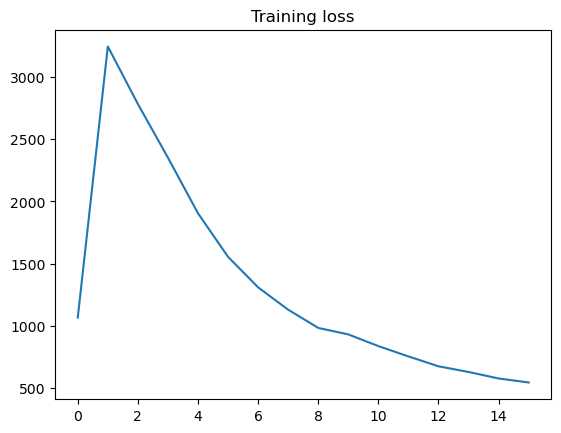

In [29]:
plt.plot(losses)
plt.title("Training loss");

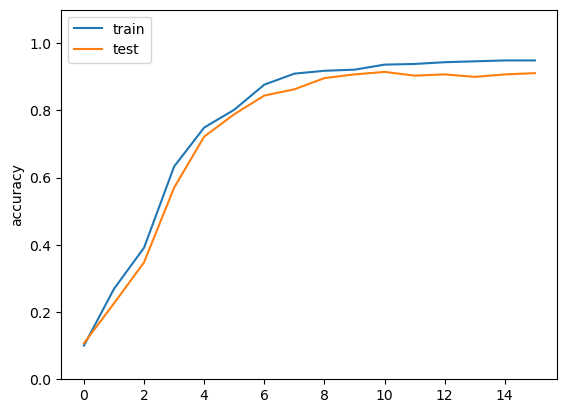

In [30]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

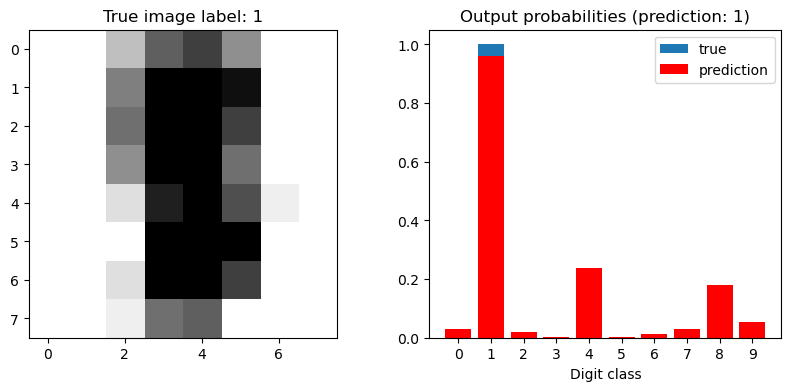

In [31]:
plot_prediction(model, sample_idx=4)

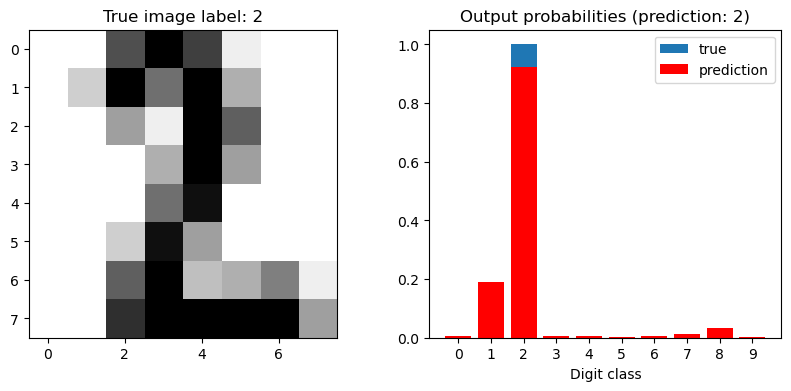

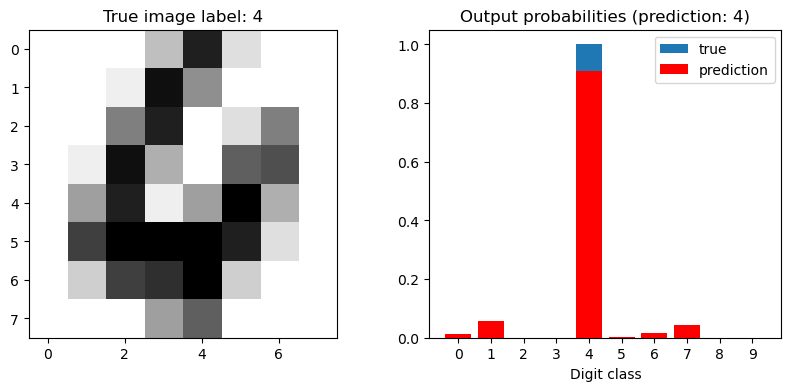

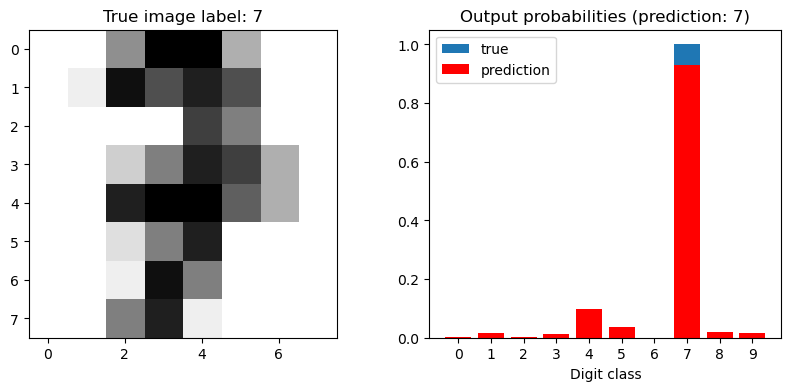

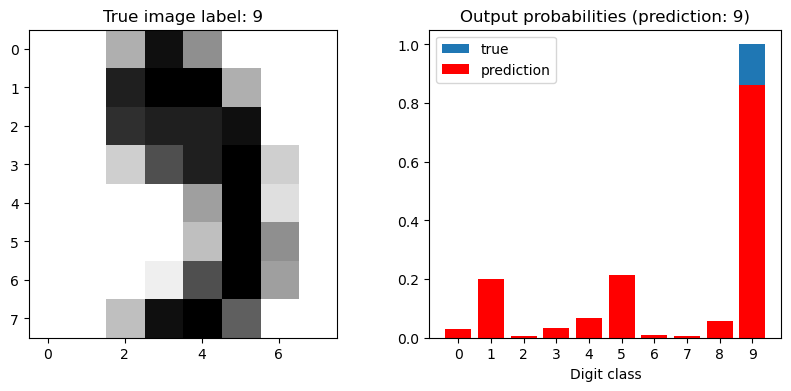

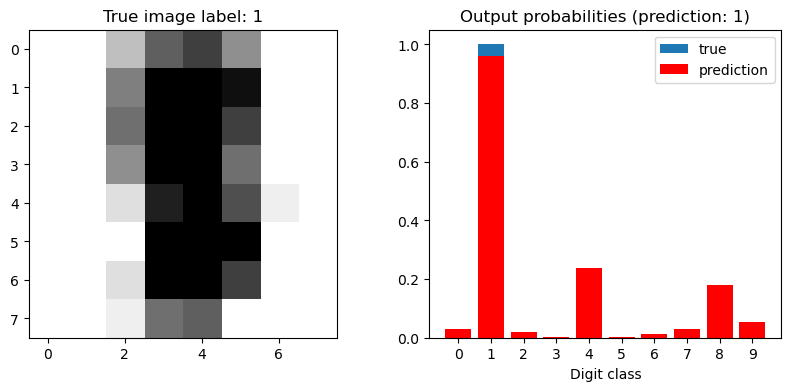

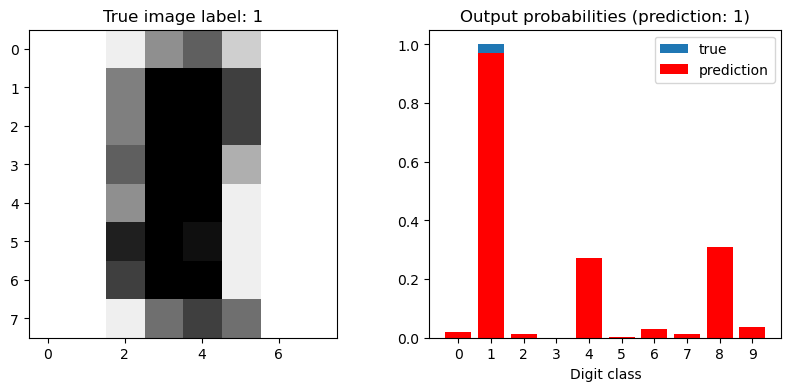

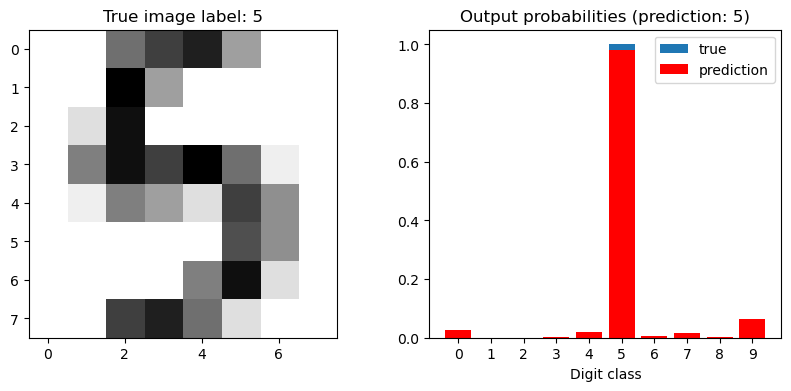

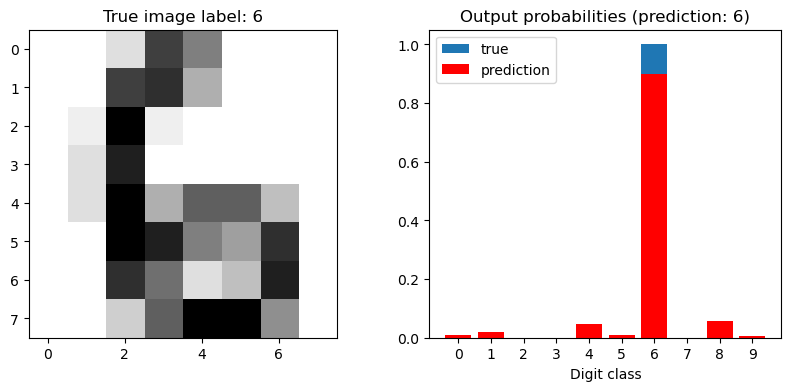

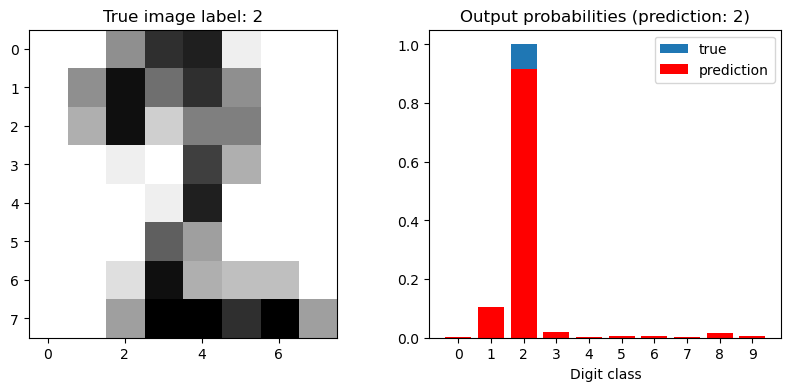

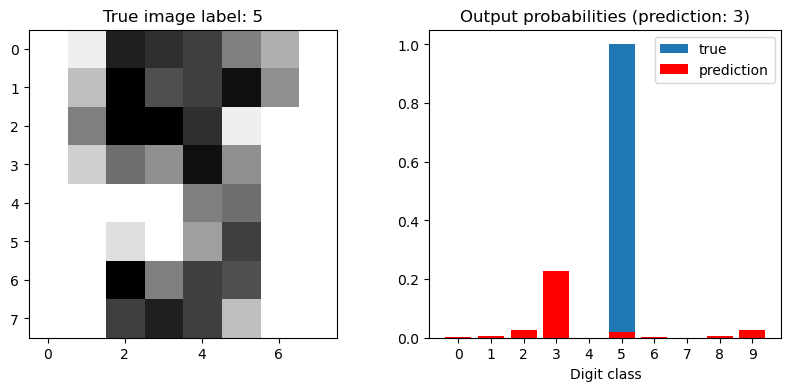

In [32]:
for i in range(10):
    plot_prediction(model, sample_idx=i)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

In [33]:
# Your code here

# 1. get the predicted probabilities for each test image
y_test_probs = model.forward(X_test)

# 2. get the predicted class for each test image
y_test_preds = np.argmax(y_test_probs, axis=1)

# 3. measure how cure the model was by extracting the highest probability
y_test_confidence = np.max(y_test_probs, axis=1)

# 4. flag incorrect predictions
y_test_pred_error_flag = y_test_preds != y_test

# 5. get the error_flag index position
y_test_pred_error_indices = np.where(y_test_pred_error_flag)[0]

# 6. sort the mistakes by lowest confidence
worst_y_test_pred_error_indices = y_test_pred_error_indices[np.argsort(y_test_confidence[y_test_pred_error_flag])[:10]]

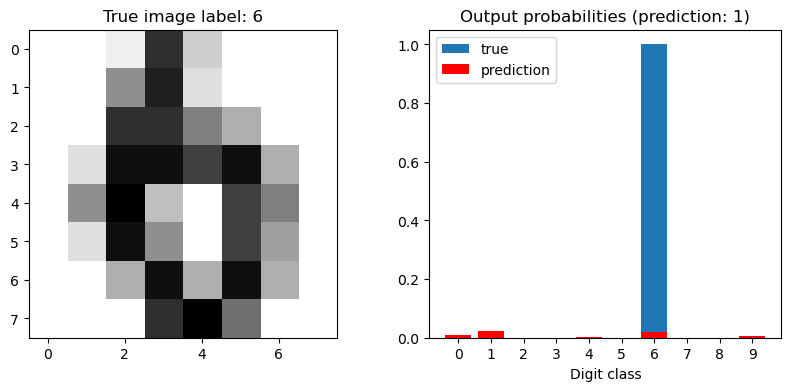

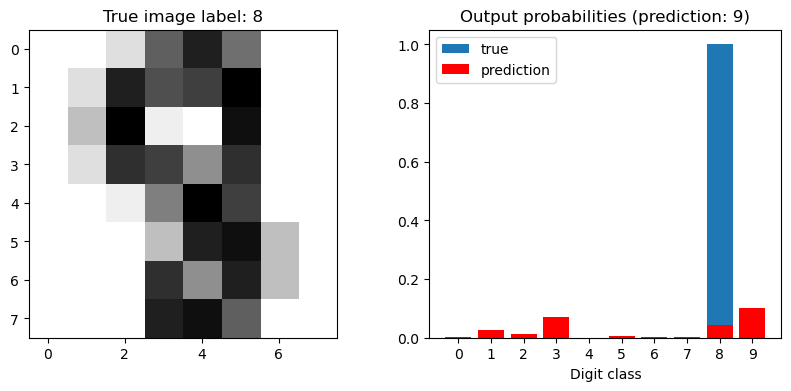

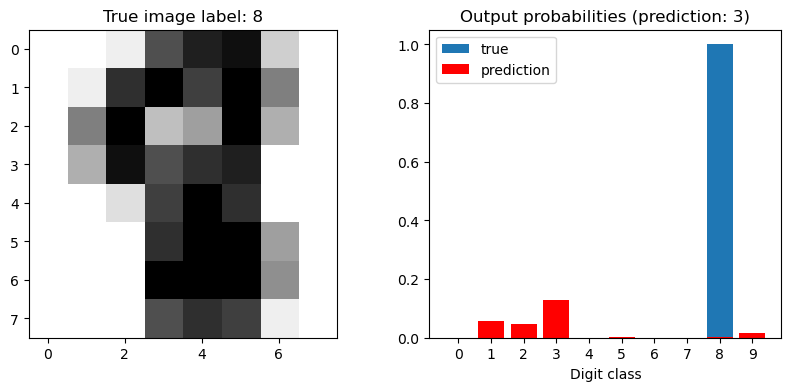

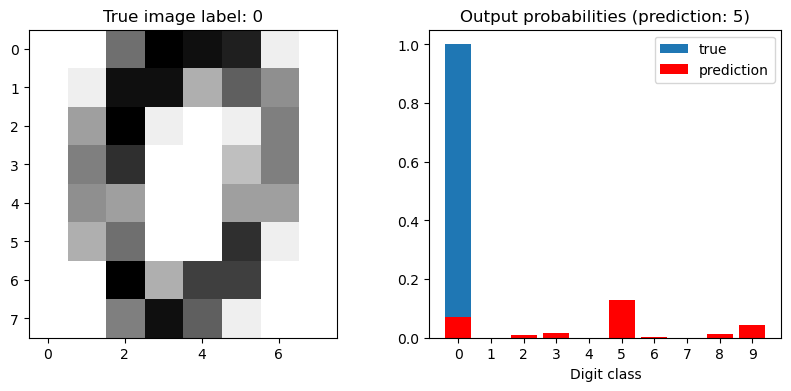

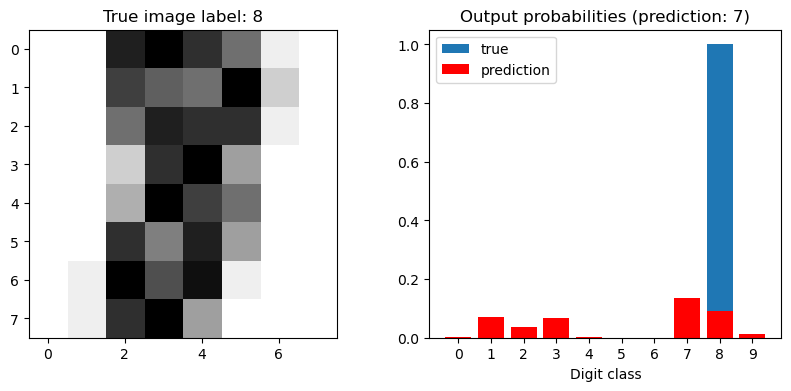

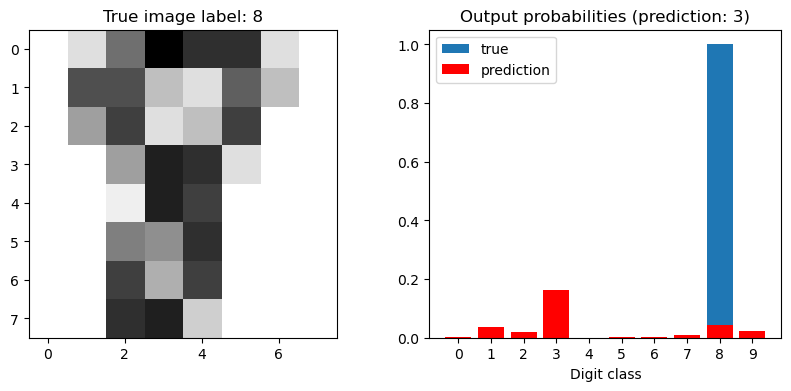

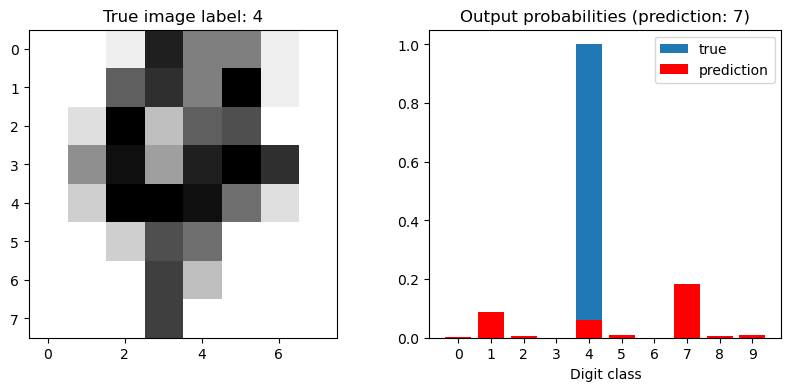

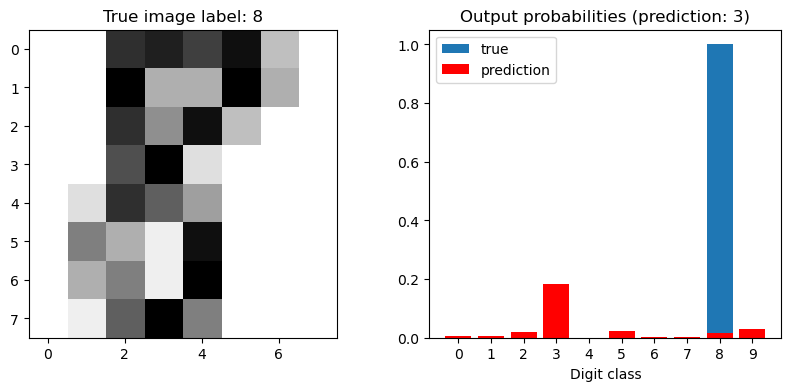

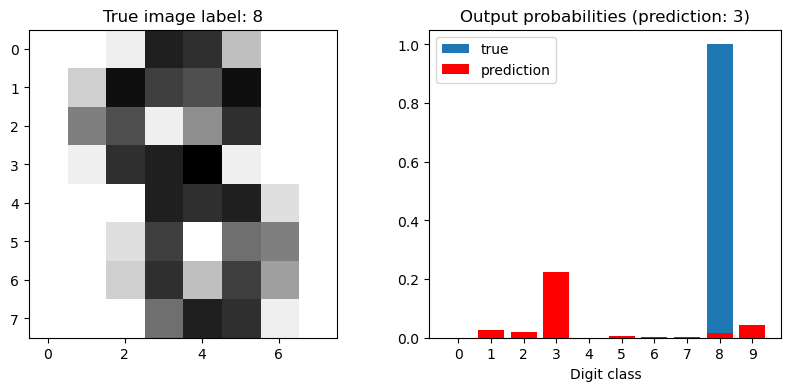

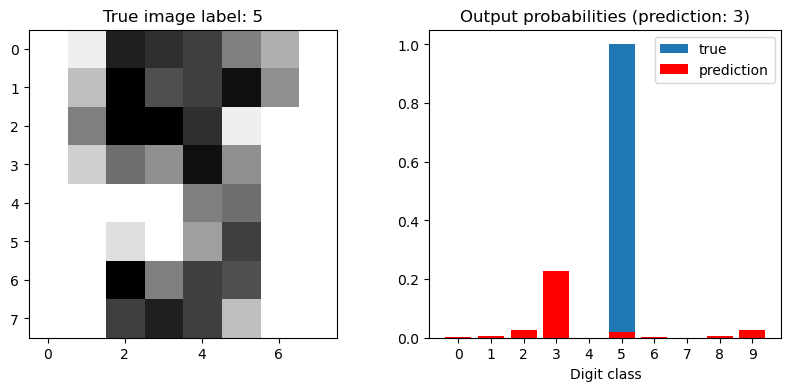

In [34]:
# Use `plot_prediction` to look at the model's worst predictions
for index in worst_y_test_pred_error_indices:
    plot_prediction(model, sample_idx=index)


**Would you have done any better?**

- I don't think I would change anything.

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [35]:
# Your code here

class  NeuralNet_extended:
    """MLP with 1 hidden layer or 2 hidden layers and sigmoid activation"""

    def __init__(self, input_size, output_size, hidden_size1=64, hidden_size2=None):
        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

        # First hidden layer
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size1), high=0.1, low=-0.1)       
        self.b_h1 = np.random.uniform(size=hidden_size1,high=0.1, low=-0.1)
        
        if hidden_size2:
            # First hidden layer
            self.W_h2 = np.random.uniform(size=(hidden_size1, hidden_size2), high=0.1, low=-0.1)       
            self.b_h2 = np.random.uniform(size=hidden_size2, high=0.1, low=-0.1)
            
            # Output layer from second hidden layer
            self.W_o = np.random.uniform(size=(hidden_size2, output_size), high=0.1, low=-0.1)
            self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        else:
            # Output layer from first hidden layer
            self.W_o = np.random.uniform(size=(hidden_size1, output_size), high=0.1, low=-0.1)
            self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        
    def forward_hidden(self, X):
        # First hidden layer
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        H1 = sigmoid(self.Z_h1)

        if self.hidden_size2:
            # Second hidden layer
            self.Z_h2 = np.dot(H1, self.W_h2) + self.b_h2
            H2 = sigmoid(self.Z_h2)
            return H2
        else:
            return H1

    def forward_output(self, H):
        self.Z_o = np.dot(H, self.W_o) + self.b_o
        return sigmoid(self.Z_o)

    def forward(self, X):
        H = self.forward_hidden(X)
        Y = self.forward_output(H)
        return Y

    def loss(self, X, y):
        y_true = one_hot(self.output_size, y.astype(int)) 
        y_pred = self.forward(X)
        return nll(y_true, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to b_o
        grad_b_o = np.sum(error_o, axis=0)

        if self.hidden_size2:
            grad_W_o = np.dot(self.Z_h2.T, error_o)
            error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)
            grad_b_h2 = np.sum(error_h2, axis=0)
            grad_W_h2 = np.dot(self.Z_h1.T, error_h2)
            error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)
        else:
            grad_W_o = np.dot(self.Z_h1.T, error_o)
            error_h1 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h1)

        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)

        grads = {"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_o": grad_W_o, "b_o": grad_b_o}

        if self.hidden_size2:
            grads.update({"W_h2": grad_W_h2, "b_h2": grad_b_h2})

        return grads

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
        if self.hidden_size2:
            self.W_h2 -= learning_rate * grads["W_h2"]
            self.b_h2 -= learning_rate * grads["b_h2"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [36]:
import random

results = {}

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

def gen_model_name(learn_rate, hidden1, hidden2=None, seed=42):
    lr_str = str(learn_rate).replace('.','p')    # 0.1 becomes 0p1
    mname = f"model_lr{lr_str}_h1{hidden1}"
    if hidden2:
        mname += f"_h2{hidden2}"
    mname += f"_seed{seed}"
    return mname

def get_fresh_data(seed=37, split_pct=0.15):
    digits = load_digits()
    data = np.asarray(digits.data, dtype='float32')
    target = np.asarray(digits.target, dtype='int32')

    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=split_pct, random_state=seed)
    return X_train, X_test, y_train, y_test
    
def run_experiment(seed, lr, hidden1, hidden2=None, num_epochs=10):
    set_seed(seed)
    X_train, X_test, y_train, y_test = get_fresh_data()

    model_name = gen_model_name(lr, hidden1, hidden2, seed)
    model = NeuralNet_extended(input_size=64, output_size=10, hidden_size1=hidden1, hidden_size2=hidden2)

    # Track metrics
    losses, accuracies, accuracies_test = [], [], []

    # Initial evaluation before training
    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))

    print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (losses[-1], accuracies[-1], accuracies_test[-1]))

    # Training loop
    for epoch in range(num_epochs):
        for x, y in zip(X_train, y_train):
            model.train(x, y, learning_rate=lr)

        # Evaluate after each epoch
        losses.append(model.loss(X_train, y_train))
        accuracies.append(model.accuracy(X_train, y_train))
        accuracies_test.append(model.accuracy(X_test, y_test))

        print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
              % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

    # Store final results
    results[model_name] = {
        'train_loss': losses[-1],
        'train_acc': accuracies[-1],
        'test_acc': accuracies_test[-1],
        'losses': losses,
        'train_acc_history': accuracies,
        'test_acc_history': accuracies_test
    }

    return model_name, accuracies_test[-1], losses[-1]


In [37]:
# starting with smaller epochs

run_experiment(seed=42, lr=0.01, hidden1=64, hidden2=None, num_epochs=5)

Random init: train loss: 1081.94049, train acc: 0.100, test acc: 0.111
Epoch #1, train loss: 472.06928, train acc: 0.880, test acc: 0.852
Epoch #2, train loss: 595.91734, train acc: 0.794, test acc: 0.774
Epoch #3, train loss: 531.76541, train acc: 0.851, test acc: 0.789
Epoch #4, train loss: 2160.55985, train acc: 0.700, test acc: 0.722
Epoch #5, train loss: 13038.08928, train acc: 0.141, test acc: 0.126


('model_lr0p01_h164_seed42', 0.1259259259259259, 13038.089284258922)

**Results**

Epoch1: excellent start with 88% in train accuracy and 85% in test accuracy.
Epoch 2-3: slight dip and recover but still solid performance.
Epoch 4: huge spike in train loss and accuracy drops to 70%
Epoch 5: catastrophic results to both accurcy and loss.

Maybe learning rate is too high.

In [39]:
# smaller learning rate

run_experiment(seed=42, lr=0.001, hidden1=64, hidden2=None, num_epochs=5)

Random init: train loss: 1081.94049, train acc: 0.100, test acc: 0.111
Epoch #1, train loss: 1577.58898, train acc: 0.832, test acc: 0.804
Epoch #2, train loss: 892.13438, train acc: 0.913, test acc: 0.889
Epoch #3, train loss: 612.91014, train acc: 0.944, test acc: 0.926
Epoch #4, train loss: 466.80419, train acc: 0.955, test acc: 0.930
Epoch #5, train loss: 380.46712, train acc: 0.967, test acc: 0.952


('model_lr0p001_h164_seed42', 0.9518518518518518, 380.46711817282744)

**Results**

- Model is learning fast: Accuracy jumps dramatically after just one epoch.

- Generalization is strong: Test accuracy closely tracks train accuracy.

- No signs of overfitting yet: Even at 96.7% train accuracy, test accuracy is still climbing.

Learning rate of 0.001 seems promissing. Next fine tune learning rates.

In [40]:
# fine tune learning rate 0.0005

run_experiment(seed=42, lr=0.0005, hidden1=64, hidden2=None, num_epochs=10)

Random init: train loss: 1081.94049, train acc: 0.100, test acc: 0.111
Epoch #1, train loss: 2288.08697, train acc: 0.740, test acc: 0.733
Epoch #2, train loss: 1574.11595, train acc: 0.842, test acc: 0.833
Epoch #3, train loss: 1161.66929, train acc: 0.899, test acc: 0.881
Epoch #4, train loss: 894.54638, train acc: 0.925, test acc: 0.904
Epoch #5, train loss: 728.85399, train acc: 0.938, test acc: 0.930
Epoch #6, train loss: 611.97480, train acc: 0.947, test acc: 0.930
Epoch #7, train loss: 527.91259, train acc: 0.956, test acc: 0.944
Epoch #8, train loss: 465.35077, train acc: 0.961, test acc: 0.952
Epoch #9, train loss: 417.18925, train acc: 0.965, test acc: 0.952
Epoch #10, train loss: 379.05142, train acc: 0.971, test acc: 0.959


('model_lr0p0005_h164_seed42', 0.9592592592592593, 379.0514212265331)

In [41]:
# fine tune learning rate 0.002

run_experiment(seed=42, lr=0.002, hidden1=64, hidden2=None, num_epochs=10)

Random init: train loss: 1081.94049, train acc: 0.100, test acc: 0.111
Epoch #1, train loss: 887.43899, train acc: 0.897, test acc: 0.859
Epoch #2, train loss: 482.02459, train acc: 0.950, test acc: 0.919
Epoch #3, train loss: 341.50161, train acc: 0.963, test acc: 0.926
Epoch #4, train loss: 268.25936, train acc: 0.972, test acc: 0.944
Epoch #5, train loss: 225.10626, train acc: 0.975, test acc: 0.952
Epoch #6, train loss: 196.77609, train acc: 0.980, test acc: 0.952
Epoch #7, train loss: 175.51765, train acc: 0.985, test acc: 0.956
Epoch #8, train loss: 157.54010, train acc: 0.986, test acc: 0.952
Epoch #9, train loss: 141.98954, train acc: 0.986, test acc: 0.952
Epoch #10, train loss: 128.88167, train acc: 0.988, test acc: 0.959


('model_lr0p002_h164_seed42', 0.9592592592592593, 128.8816713950375)

In [42]:
run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=None, num_epochs=10)

Random init: train loss: 1081.94049, train acc: 0.100, test acc: 0.111
Epoch #1, train loss: 1164.38686, train acc: 0.874, test acc: 0.859
Epoch #2, train loss: 611.75668, train acc: 0.937, test acc: 0.919
Epoch #3, train loss: 424.07283, train acc: 0.957, test acc: 0.922
Epoch #4, train loss: 329.57801, train acc: 0.966, test acc: 0.941
Epoch #5, train loss: 273.07201, train acc: 0.972, test acc: 0.952
Epoch #6, train loss: 236.10742, train acc: 0.977, test acc: 0.952
Epoch #7, train loss: 209.95618, train acc: 0.982, test acc: 0.956
Epoch #8, train loss: 189.76804, train acc: 0.984, test acc: 0.959
Epoch #9, train loss: 173.20396, train acc: 0.985, test acc: 0.963
Epoch #10, train loss: 159.14526, train acc: 0.986, test acc: 0.967


('model_lr0p0015_h164_seed42', 0.9666666666666667, 159.14525731717623)

**Results**

model_lr0p0015_h164_seed42 with lr = 0.0015 is not only learning efficiently but also generalizing beautifully.

- Final Train Accuracy: 98.6
- Final Test Accuracy: 96.7 (Best so far)
- Final Train Loss: 159.15

lr=0.0015 is the best learning rate tested.


In [43]:
run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=None, num_epochs=15)

Random init: train loss: 1081.94049, train acc: 0.100, test acc: 0.111
Epoch #1, train loss: 1164.38686, train acc: 0.874, test acc: 0.859
Epoch #2, train loss: 611.75668, train acc: 0.937, test acc: 0.919
Epoch #3, train loss: 424.07283, train acc: 0.957, test acc: 0.922
Epoch #4, train loss: 329.57801, train acc: 0.966, test acc: 0.941
Epoch #5, train loss: 273.07201, train acc: 0.972, test acc: 0.952
Epoch #6, train loss: 236.10742, train acc: 0.977, test acc: 0.952
Epoch #7, train loss: 209.95618, train acc: 0.982, test acc: 0.956
Epoch #8, train loss: 189.76804, train acc: 0.984, test acc: 0.959
Epoch #9, train loss: 173.20396, train acc: 0.985, test acc: 0.963
Epoch #10, train loss: 159.14526, train acc: 0.986, test acc: 0.967
Epoch #11, train loss: 147.05413, train acc: 0.987, test acc: 0.970
Epoch #12, train loss: 136.61508, train acc: 0.988, test acc: 0.970
Epoch #13, train loss: 127.55194, train acc: 0.990, test acc: 0.974
Epoch #14, train loss: 119.58941, train acc: 0.991, t

('model_lr0p0015_h164_seed42', 0.9740740740740741, 112.4730780635876)

**Best results:** Consistent improvement with lr = 0.0015, hidden1 = 64, epochs = 15

In [44]:
# Next add a second hidden layer

run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=32, num_epochs=15)

Random init: train loss: 1061.01631, train acc: 0.102, test acc: 0.096
Epoch #1, train loss: 3490.23859, train acc: 0.109, test acc: 0.063
Epoch #2, train loss: 3488.23549, train acc: 0.109, test acc: 0.063
Epoch #3, train loss: 3425.20737, train acc: 0.193, test acc: 0.144
Epoch #4, train loss: 3147.88038, train acc: 0.208, test acc: 0.159
Epoch #5, train loss: 2766.89595, train acc: 0.223, test acc: 0.174
Epoch #6, train loss: 2470.50389, train acc: 0.395, test acc: 0.352
Epoch #7, train loss: 2116.55418, train acc: 0.606, test acc: 0.570
Epoch #8, train loss: 1746.38286, train acc: 0.684, test acc: 0.644
Epoch #9, train loss: 1422.28399, train acc: 0.796, test acc: 0.759
Epoch #10, train loss: 1162.62411, train acc: 0.844, test acc: 0.789
Epoch #11, train loss: 976.16375, train acc: 0.867, test acc: 0.819
Epoch #12, train loss: 832.76052, train acc: 0.898, test acc: 0.859
Epoch #13, train loss: 712.56062, train acc: 0.924, test acc: 0.907
Epoch #14, train loss: 609.94200, train acc:

('model_lr0p0015_h164_h232_seed42', 0.9518518518518518, 523.7207854434112)

**Results**

**Performance Comparison: 1 Hidden Layer vs 2 Hidden Layers**

| Configuration                  | Final Test Accuracy | Final Train Accuracy | Final Train Loss |
|-------------------------------|----------------------|-----------------------|------------------|
| **1 hidden layer (64 units)** | **97.4%**            | 99.2%                 | 112.47           |
| **2 hidden layers (64 + 32)** | 95.2%                | 95.6%                 | 523.72           |

- The single hidden layer model learns faster and generalizes better on this dataset.
- The deeper model starts slow and requires more epochs to catch up, but still underperforms slightly.
- For this task, simpler architecture yields better results.


In [45]:
# Test with larger hidden2=64 values

run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=64, num_epochs=15)

Random init: train loss: 1122.83243, train acc: 0.099, test acc: 0.115
Epoch #1, train loss: 3496.12477, train acc: 0.188, test acc: 0.130
Epoch #2, train loss: 3405.25894, train acc: 0.231, test acc: 0.193
Epoch #3, train loss: 3019.39629, train acc: 0.311, test acc: 0.256
Epoch #4, train loss: 2550.35325, train acc: 0.448, test acc: 0.411
Epoch #5, train loss: 2084.04181, train acc: 0.670, test acc: 0.648
Epoch #6, train loss: 1581.44444, train acc: 0.801, test acc: 0.785
Epoch #7, train loss: 1197.83867, train acc: 0.868, test acc: 0.848
Epoch #8, train loss: 906.48244, train acc: 0.904, test acc: 0.907
Epoch #9, train loss: 710.58939, train acc: 0.924, test acc: 0.930
Epoch #10, train loss: 579.99070, train acc: 0.944, test acc: 0.944
Epoch #11, train loss: 484.78685, train acc: 0.957, test acc: 0.948
Epoch #12, train loss: 410.47445, train acc: 0.965, test acc: 0.952
Epoch #13, train loss: 352.03741, train acc: 0.972, test acc: 0.967
Epoch #14, train loss: 306.05860, train acc: 0.

('model_lr0p0015_h164_h264_seed42', 0.9740740740740741, 269.4452680693489)

**Results**

**Performance Comparison: 1 Hidden Layer vs 2 Hidden Layers**

| Configuration                  | Final Test Accuracy | Final Train Accuracy | Final Train Loss |
|-------------------------------|----------------------|-----------------------|------------------|
| **1 hidden layer (64 units)** | **97.4%**            | 99.2%                 | 112.47           |
| **2 hidden layers (64 + 64)** | **97.4%**            | 97.8%                 | 269.45           |

- The deeper model took longer to warm up but eventually matched the test accuracy of the simpler model.
- Train accuracy and loss are slightly lower, suggesting simpler architecture still yields better results.

In [46]:
# Test with larger hidden2=128 values

run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=128, num_epochs=15)

Random init: train loss: 1201.12357, train acc: 0.102, test acc: 0.089
Epoch #1, train loss: 3400.92761, train acc: 0.244, test acc: 0.226
Epoch #2, train loss: 2968.74630, train acc: 0.476, test acc: 0.415
Epoch #3, train loss: 2278.84006, train acc: 0.600, test acc: 0.578
Epoch #4, train loss: 1735.12083, train acc: 0.787, test acc: 0.756
Epoch #5, train loss: 1278.55996, train acc: 0.851, test acc: 0.822
Epoch #6, train loss: 969.61109, train acc: 0.890, test acc: 0.856
Epoch #7, train loss: 749.84912, train acc: 0.923, test acc: 0.889
Epoch #8, train loss: 590.09643, train acc: 0.943, test acc: 0.922
Epoch #9, train loss: 474.91836, train acc: 0.961, test acc: 0.944
Epoch #10, train loss: 392.71020, train acc: 0.972, test acc: 0.948
Epoch #11, train loss: 332.42346, train acc: 0.976, test acc: 0.963
Epoch #12, train loss: 286.75010, train acc: 0.980, test acc: 0.963
Epoch #13, train loss: 251.01719, train acc: 0.980, test acc: 0.967
Epoch #14, train loss: 222.24254, train acc: 0.98

('model_lr0p0015_h164_h2128_seed42', 0.9666666666666667, 198.62992025002245)

**Results**

**Performance Comparison: 1 Hidden Layer vs 2 Hidden Layers**

| Configuration                   | Final Test Accuracy | Final Train Accuracy | Final Train Loss |
|--------------------------------|----------------------|-----------------------|------------------|
| **1 hidden layer (64 units)**  | **97.4%**            | 99.2%                 | 112.47           |
| **2 hidden layers (64 + 64)**  | **97.4%**            | 97.8%                 | 269.45           |
| **2 hidden layers (64 + 128)** | **97.4%**            | 97.8%                 | 269.45           |
| **2 hidden layers (64 + 256)** | 96.7%          | **98.4%**                 | 198.63           |

- All configurations reach similar peak test accuracy.
- The single-layer model is the most efficient — faster convergence and lower final loss.
- Deeper models take longer to warm up but generalize well even the single-layer model still out perform the 2 hidden layer configuration.


In [47]:
# Test with larger hidden2=256 values

run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=256, num_epochs=15)

Random init: train loss: 893.04784, train acc: 0.107, test acc: 0.063
Epoch #1, train loss: 3279.18442, train acc: 0.302, test acc: 0.278
Epoch #2, train loss: 2481.99591, train acc: 0.688, test acc: 0.637
Epoch #3, train loss: 1666.30575, train acc: 0.813, test acc: 0.789
Epoch #4, train loss: 1135.68851, train acc: 0.872, test acc: 0.844
Epoch #5, train loss: 801.85441, train acc: 0.917, test acc: 0.904
Epoch #6, train loss: 582.36888, train acc: 0.948, test acc: 0.933
Epoch #7, train loss: 447.06666, train acc: 0.963, test acc: 0.937
Epoch #8, train loss: 362.80517, train acc: 0.971, test acc: 0.956
Epoch #9, train loss: 306.15150, train acc: 0.975, test acc: 0.959
Epoch #10, train loss: 265.03666, train acc: 0.978, test acc: 0.963
Epoch #11, train loss: 233.17032, train acc: 0.980, test acc: 0.967
Epoch #12, train loss: 207.44293, train acc: 0.983, test acc: 0.967
Epoch #13, train loss: 186.42289, train acc: 0.984, test acc: 0.974
Epoch #14, train loss: 169.05953, train acc: 0.984,

('model_lr0p0015_h164_h2256_seed42', 0.9740740740740741, 154.40947826886577)

In [48]:
# Test with larger hidden2=512 values

run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=512, num_epochs=15)

Random init: train loss: 1204.57401, train acc: 0.099, test acc: 0.115
Epoch #1, train loss: 2798.35425, train acc: 0.586, test acc: 0.537
Epoch #2, train loss: 1733.09777, train acc: 0.812, test acc: 0.781
Epoch #3, train loss: 1048.56064, train acc: 0.887, test acc: 0.874
Epoch #4, train loss: 708.17653, train acc: 0.934, test acc: 0.930
Epoch #5, train loss: 512.26882, train acc: 0.957, test acc: 0.937
Epoch #6, train loss: 396.29064, train acc: 0.967, test acc: 0.944
Epoch #7, train loss: 321.64801, train acc: 0.976, test acc: 0.952
Epoch #8, train loss: 270.22053, train acc: 0.983, test acc: 0.967
Epoch #9, train loss: 232.90936, train acc: 0.985, test acc: 0.967
Epoch #10, train loss: 204.45332, train acc: 0.986, test acc: 0.967
Epoch #11, train loss: 181.89745, train acc: 0.986, test acc: 0.967
Epoch #12, train loss: 163.56881, train acc: 0.987, test acc: 0.970
Epoch #13, train loss: 148.41089, train acc: 0.988, test acc: 0.978
Epoch #14, train loss: 135.67839, train acc: 0.988,

('model_lr0p0015_h164_h2512_seed42', 0.9777777777777777, 124.84106528443391)

In [49]:
# Test with larger hidden2=1024 values

run_experiment(seed=42, lr=0.0015, hidden1=64, hidden2=1024, num_epochs=15)

Random init: train loss: 1128.51807, train acc: 0.104, test acc: 0.093
Epoch #1, train loss: 2045.13235, train acc: 0.755, test acc: 0.744
Epoch #2, train loss: 1094.99905, train acc: 0.893, test acc: 0.859
Epoch #3, train loss: 673.39635, train acc: 0.940, test acc: 0.919
Epoch #4, train loss: 472.63761, train acc: 0.958, test acc: 0.941
Epoch #5, train loss: 363.70225, train acc: 0.968, test acc: 0.959
Epoch #6, train loss: 296.04255, train acc: 0.970, test acc: 0.959
Epoch #7, train loss: 249.43580, train acc: 0.976, test acc: 0.959
Epoch #8, train loss: 214.87701, train acc: 0.979, test acc: 0.967
Epoch #9, train loss: 187.80708, train acc: 0.981, test acc: 0.967
Epoch #10, train loss: 166.00170, train acc: 0.984, test acc: 0.970
Epoch #11, train loss: 148.14212, train acc: 0.988, test acc: 0.974
Epoch #12, train loss: 133.31405, train acc: 0.989, test acc: 0.974
Epoch #13, train loss: 120.83224, train acc: 0.990, test acc: 0.974
Epoch #14, train loss: 110.12095, train acc: 0.991, 

('model_lr0p0015_h164_h21024_seed42', 0.9777777777777777, 100.82933038181073)

In [50]:
# Test with larger hidden1=128 and hidden2=1024 values

run_experiment(seed=42, lr=0.0015, hidden1=128, hidden2=1024, num_epochs=15)

Random init: train loss: 684.48115, train acc: 0.100, test acc: 0.078
Epoch #1, train loss: 1520.55692, train acc: 0.832, test acc: 0.800
Epoch #2, train loss: 788.26046, train acc: 0.909, test acc: 0.904
Epoch #3, train loss: 512.08429, train acc: 0.950, test acc: 0.933
Epoch #4, train loss: 377.73770, train acc: 0.963, test acc: 0.941
Epoch #5, train loss: 300.79353, train acc: 0.971, test acc: 0.959
Epoch #6, train loss: 250.72687, train acc: 0.976, test acc: 0.963
Epoch #7, train loss: 215.14235, train acc: 0.982, test acc: 0.967
Epoch #8, train loss: 188.51442, train acc: 0.984, test acc: 0.970
Epoch #9, train loss: 167.82373, train acc: 0.986, test acc: 0.970
Epoch #10, train loss: 150.72034, train acc: 0.988, test acc: 0.970
Epoch #11, train loss: 136.00675, train acc: 0.990, test acc: 0.974
Epoch #12, train loss: 123.12886, train acc: 0.991, test acc: 0.974
Epoch #13, train loss: 111.81881, train acc: 0.991, test acc: 0.974
Epoch #14, train loss: 101.88163, train acc: 0.992, te

('model_lr0p0015_h1128_h21024_seed42', 0.9740740740740741, 93.14967529600924)

In [51]:
# Test with larger hidden1=256 and hidden2=1024 values

run_experiment(seed=42, lr=0.0015, hidden1=256, hidden2=1024, num_epochs=15)

Random init: train loss: 1348.77361, train acc: 0.099, test acc: 0.074
Epoch #1, train loss: 1034.01397, train acc: 0.891, test acc: 0.878
Epoch #2, train loss: 556.96763, train acc: 0.941, test acc: 0.911
Epoch #3, train loss: 388.41714, train acc: 0.955, test acc: 0.941
Epoch #4, train loss: 305.04824, train acc: 0.969, test acc: 0.944
Epoch #5, train loss: 254.12990, train acc: 0.975, test acc: 0.959
Epoch #6, train loss: 218.78529, train acc: 0.978, test acc: 0.963
Epoch #7, train loss: 192.07054, train acc: 0.980, test acc: 0.970
Epoch #8, train loss: 170.81466, train acc: 0.982, test acc: 0.970
Epoch #9, train loss: 153.34681, train acc: 0.984, test acc: 0.970
Epoch #10, train loss: 138.64801, train acc: 0.986, test acc: 0.970
Epoch #11, train loss: 126.03960, train acc: 0.987, test acc: 0.970
Epoch #12, train loss: 115.05985, train acc: 0.990, test acc: 0.970
Epoch #13, train loss: 105.39521, train acc: 0.990, test acc: 0.970
Epoch #14, train loss: 96.82721, train acc: 0.991, te

('model_lr0p0015_h1256_h21024_seed42', 0.9740740740740741, 89.19358481514936)

**Results**

**Performance Comparison: 1 Hidden Layer vs 2 Hidden Layers**

| Configuration                    | Final Test Accuracy | Final Train Accuracy | Final Train Loss |
|----------------------------------|----------------------|-----------------------|------------------|
| **1 hidden layer (64 units)**   | 97.4%                | 99.2%                 | 112.47           |
| **2 hidden layers (64 + 256)**  | 97.4%                | 98.6%                 | 154.41           |
| **2 hidden layers (64 + 512)**  | **97.8%** *         | 99.0%                 | 124.84           |
| **2 hidden layers (64 + 1024)** | **97.8%** *         | 99.1%                 | 100.83           |
| **2 hidden layers (256 + 1024)**| 97.4%                | **99.3%**             | **89.19** *      |

- The **(256 + 1024)** model has the **lowest train loss** and **highest train accuracy**, indicating excellent fit.
- However, it does **not surpass** the test accuracy of the **(64 + 512)** or **(64 + 1024)** models.
- This suggests **diminishing returns** in test performance despite increased capacity.


**What is the best test accuracy you can get?**



- Based on all the experients, the configuration with two hidden layers (64 + 1024 neurons) and a learning rate of 0.0015 currently produce the best test accuracy.